# Source Catalog Loading, Plotting and Exploring Examples

In [1]:
import numpy as np
import os.path as op
import requests

from astropy.table import Table, unique

from hetdex_tools.source_catalog import plot_source_group
from hetdex_api.elixer_widget_cls import ElixerWidget
from hetdex_api.query_widget import QueryWidget
from hetdex_api.amp_widget import AmpWidget
from hetdex_api.config import HDRconfig

This catalog is a combination of sources from the continuum source catalog, the curated detection line catalog of the same version and the confirmed AGN detection IDs from Chenxu Liu's AGN search. Each row is for a detection and its unique catalog detectid. Detectid's of AGN sources *may* appear twice if they are also found in the continuum or curated line catalogs. This is intentional as information about the detection type is used to guess the redshift of the sources. The column `'det_type'` can be `['line','cont','agn']`. The column "source_type" describes the source classifcation 'agn','lae', 'oii', 'star', 'lzg'(low-z galaxy without line emission), 'unsure' and 'z_hetdex' provides the best redshift which is a combination of Diagnose redshifts (g<22), Elixer redshifts (g>22) and AGN redshifts.

### Column Info can be found here:


https://op1srv.mpe.mpg.de/wikihetdex/index.php/Column_Info


In [12]:
# Open the catalog. We can use HDRconfig to identify the system path

In [40]:
# Enter the catalog version

version = '4.0.0'
hdrv = 'hdr{}'.format(version[0])
config = HDRconfig()
catfile = op.join(config.hdr_dir[hdrv], 'catalogs', 'source_catalog_' + version + '.fits')
source_table = Table.read(catfile)

print('Source catalog was found at {}'.format(catfile))

Source catalog was found at /scratch/projects/hetdex/hdr4/catalogs/source_catalog_4.0.0.fits


In [41]:
for col in source_table.columns:
    print(col,source_table[col].dtype)
    try:
        source_table[col] = source_table[col].filled(np.nan)
    except:
        pass

source_id >i8
source_name |S26
detectid >i8
flag_best >i8
n_members >i8
lum >f4
ra_mean >f4
dec_mean >f4
icz >f4
ixx >f4
iyy >f4
ixy >f4
izz >f4
a >f8
b >f8
pa >f8
a2 >f8
b2 >f8
pa2 >f8
wave_group_id >i8
wave_group_a >f8
wave_group_b >f8
wave_group_pa >f8
wave_group_ra >f4
wave_group_dec >f4
wave_group_wave >f4
fwhm >f8
throughput >f8
fluxlimit_4540 >f8
shotid >i8
field |S12
n_ifu >i8
ra >f4
dec >f4
date >i4
obsid >i4
wave >f4
wave_err >f4
flux >f8
flux_err >f8
linewidth >f4
linewidth_err >f4
continuum >f8
continuum_err >f8
sn >f4
sn_err >f4
chi2 >f4
chi2_err >f4
multiframe |S20
fibnum >i4
x_raw >i4
y_raw >i4
amp |S2
apcor >f8
chi2fib >f4
expnum >i4
fiber_id |S38
flux_noise_1sigma >f8
ifuid |S3
ifuslot |S3
inputid |S40
noise_ratio >f4
sn_3fib >f8
sn_3fib_cen >f8
sn_cen >f8
specid |S3
weight >f4
x_ifu >f4
y_ifu >f4
det_type |S4
flag_baddet >i8
gmag >f4
plya_classification >f4
z_elixer >f4
best_pz >f4
combined_plae >f4
combined_plae_lo >f4
combined_plae_hi >f4
flags >i4
classification_la

In [47]:
source_table['raic_streak'].filled(1)

-1
0
-1
0
-1
0
0
-1
-1
-1
0


### NEW!!! We will continue to update the bad detection list on github. These can be removed from the catalog using this cell.

In [13]:
# set to true to update flags for all newly found bad detects since catalog release
update_baddets = True

if update_baddets:
    current_good_dets = np.array(source_table['detectid'][source_table['flag_baddet'] == 1])
    baddets = np.array( [int(det) for det in requests.get('https://raw.githubusercontent.com/HETDEX/hetdex_api/master/known_issues/hdr3/baddetects.list').text.split('\n')])
    
    update_these_dets = np.intersect1d( current_good_dets, baddets)

    for baddet in update_these_dets:
        print('Updating flag for {}'.format(baddet))
        sel_det = source_table['detectid'] == baddet
        if source_table['flag_baddet'][sel_det] == 1:
            source_table['flag_baddet'][sel_det] = 0
            source_table['flag_best'][sel_det] = 0

In [14]:
source_table.columns

<TableColumns names=('source_id','source_name','detectid','flag_best','n_members','lum','ra_mean','dec_mean','icz','ixx','iyy','ixy','izz','a','b','pa','a2','b2','pa2','wave_group_id','wave_group_a','wave_group_b','wave_group_pa','wave_group_ra','wave_group_dec','wave_group_wave','fwhm','throughput','fluxlimit_4540','shotid','field','n_ifu','ra','dec','date','obsid','wave','wave_err','flux','flux_err','linewidth','linewidth_err','continuum','continuum_err','sn','sn_err','chi2','chi2_err','multiframe','fibnum','x_raw','y_raw','amp','apcor','chi2fib','expnum','fiber_id','flux_noise_1sigma','ifuid','ifuslot','inputid','noise_ratio','sn_3fib','sn_3fib_cen','sn_cen','specid','weight','x_ifu','y_ifu','det_type','flag_baddet','gmag','plya_classification','z_elixer','best_pz','combined_plae','combined_plae_lo','combined_plae_hi','flags','classification_labels','counterpart_ra','counterpart_dec','counterpart_mag','counterpart_mag_err','counterpart_dist','counterpart_catalog_name','counterpart_f

You can sort the table using the `unique` function from `astropy.table` on the `source_id` key. For nearby galaxies, stars and AGN, many detectids can comprise the same source (ie. the same `source_id`). When you reduce the catalog using the `unique` function, only 1 detectid remains for the source. It is sorted such that the source with a wavelength matching the `z_guess` value is selected and the detectid is located close to the positional center of the source group. 

In [9]:
# selecting for S/N>=4.8line sources and all continuum + AGN sources
sel_sn = (source_table['sn'] >= 5.5) & (source_table['det_type'] == 'line')
sel_good = (source_table['flag_best'] == 1) * (source_table['flag_erin_cuts']==1)
sel_det = source_table['selected_det'] == True
sel_agn = source_table['source_type']=='agn'
sel_cont = source_table['det_type'] == 'cont'
sel_cat = (sel_sn | sel_cont | sel_agn) & sel_det & sel_good
uniq_table = unique(source_table[sel_cat], keys='source_id')

In [10]:
star = uniq_table['source_id'][uniq_table['source_type'] == 'star']
oii = uniq_table['source_id'][uniq_table['source_type'] == 'oii']
lae = uniq_table['source_id'][uniq_table['source_type'] == 'lae']
agn = uniq_table['source_id'][uniq_table['source_type'] == 'agn']
lzg = uniq_table['source_id'][uniq_table['source_type'] == 'lzg']

print('There are {} low-z gals, {} stars, {} OII emitters, {} AGN, and {} LAEs'. \
      format(np.size(lzg), np.size(star), np.size(oii), np.size(agn), np.size(lae)))

There are 4980 low-z gals, 8672 stars, 329027 OII emitters, 5715 AGN, and 181547 LAEs


## Here is an example of plotting a group

In [27]:
%matplotlib inline

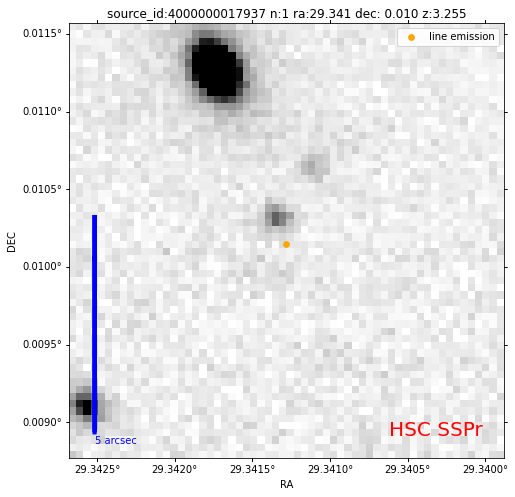

interactive(children=(Text(value='3000331288', description='DetectID:', placeholder='3000331288'), Output()), …

In [28]:
# the source_ids are sorted by member number ('n_member' in the catalog)
# This is how many detections are found in the source_id group

# Here's a query for high S/N LAEs
sel = (uniq_table['source_type'] == 'lae') & (uniq_table['sn'] > 6.5)
sid = uniq_table['source_id'][sel][301]

# Index a star 
#sid = star[100]

# Index an OII galaxy
#sid = oii[0]

# Index an LAE
#sid = lae[0]

# Index the AGN list:
#sid = agn[0]

# This step grabs the source group so we can look at each source in Elixer
sel_group = (source_table['source_id'] == sid) 
group = source_table[sel_group]

#print(sid)
#print(group)

# this function overplots the source group over an image
# use label=True to see detectid's on image
# use save=True to save the image to you working directory
# the size of the line emission is scaled to the S/N of the line

plot_source_group(source_id = sid, source_table = source_table, label = False, save = False)
EW = ElixerWidget(detectlist = source_table['detectid'][sel_group])

## Follow a detection in the 2D image with AmpWidget 

This will map the detectid from the ElixerWidget above to the amp widget. The detection's highest weight fiber is marked with a red circle at the emission line wavelength.

In [31]:
AW = AmpWidget(detectid = EW.detid)

## Follow up with QueryWidget

You can extract fibers on demand around the detection via QueryWiget:

In [32]:
QW = QueryWidget(detectid = EW.detid)

## Exploring fun with plotly 

In [ ]:
import plotly.express as px

In [ ]:
df = source_table[source_table['sn']>5.5].to_pandas()

In [ ]:
df['marker_size'] = 3
fig = px.scatter(df, 
                 template='plotly', 
                 x='sn', y='z_hetdex', 
                 color='source_type', 
                 size='marker_size', 
                 size_max=3, 
                 marginal_y='histogram', 
                 marginal_x='histogram',
                 hover_data=['detectid','source_id'])
fig.show()